In [1]:
import torch
import random
import torch.nn.functional as F
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
with open('names.txt', 'r') as f:
  names = f.read().split()
names[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
chars = sorted(set(''.join(names)))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(stoi)
print(itos)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [4]:
block_size = 3

def build_dataset(names):
  X, Y = [], []
  for name in names:
    context = [0] * block_size
    for ch in name + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]
  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

random.shuffle(names)
n1 = int(0.8 * len(names)) # 80% for training
n2 = int(0.9 * len(names)) # 10% for validation and same for testing

Xtr, Ytr = build_dataset(names[:n1])
Xdev, Ydev = build_dataset(names[n1:n2])
Xte, Yte = build_dataset(names[n2:])

torch.Size([182516, 3]) torch.Size([182516])
torch.Size([22774, 3]) torch.Size([22774])
torch.Size([22856, 3]) torch.Size([22856])


In [5]:
# two layer MLP
n_embd = 10
n_hidden = 200
vocab_size = len(stoi)

C = torch.randn((vocab_size, n_embd)) # random vectors to represent the vocabulary
W1 = torch.randn((n_embd * block_size, n_hidden))
b1 = torch.randn(n_hidden)
W2 = torch.randn((n_hidden, vocab_size))
b2 = torch.randn(27)

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


In [6]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  emb = C[Xb] # (32x3x2)
  embcat = emb.view(emb.shape[0], -1) # (32x6)
  hpreact = embcat @ W1 + b1 # (32x6) @ (6x200) + (200) --> (32x200)
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2 # (32x200) @ (200x27) + (27) --> (32x27)
  loss = F.cross_entropy(logits, Yb)

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = .1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 32.659370
  10000/ 200000: 2.700852
  20000/ 200000: 2.120794
  30000/ 200000: 2.544875
  40000/ 200000: 2.310742
  50000/ 200000: 2.703320
  60000/ 200000: 2.197710
  70000/ 200000: 2.750000
  80000/ 200000: 2.198277
  90000/ 200000: 2.220475
 100000/ 200000: 2.513240
 110000/ 200000: 2.088158
 120000/ 200000: 2.675788
 130000/ 200000: 2.380295
 140000/ 200000: 2.360132
 150000/ 200000: 2.075648
 160000/ 200000: 2.373799
 170000/ 200000: 2.215937
 180000/ 200000: 1.812862
 190000/ 200000: 1.844504


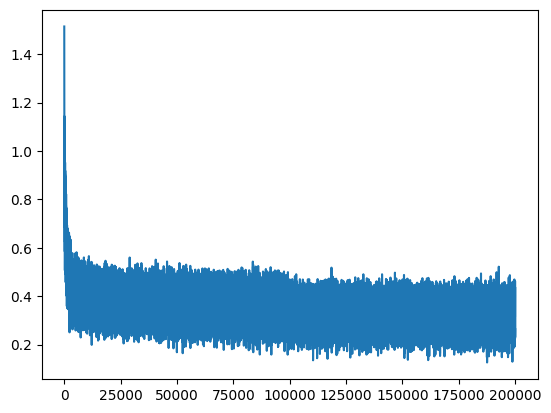

In [7]:
plt.plot(lossi)

In [8]:
@torch.no_grad()
def split_loss(split):
  x,y = {
      'train': (Xtr, Ytr),
      'val': (Xdev, Ydev),
      'test': (Xte, Yte),
  }[split]
  emb = C[x]
  embcat = emb.view(emb.shape[0], -1)
  h = torch.tanh(embcat @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

In [9]:
split_loss('train')
split_loss('val')

train 2.1322224140167236
val 2.170822858810425


In [10]:
# sample from the model
for _ in range(20):
  out = []
  context = [0] * block_size
  while True:
    emb = C[torch.tensor([context])]
    h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break

  print(''.join(itos[i] for i in out))

sadan.
juria.
dae.
davie.
with.
evantra.
shaylee.
shan.
alee.
eleyna.
imani.
diryana.
anulitklisy.
amareighrahviah.
melin.
kelia.
hateyne.
judan.
noima.
shakelbe.


# Initial Loss

It is almost the case that we can guess the initial loss that we would expect at the start of the training. It depends on the problem and the loss function. In our case, we should expect that all characters are equally probable at the initialization, thus the initial loss should be:

In [11]:
-torch.tensor(1/27.).log()

tensor(3.2958)

Let's check the initial loss:

In [12]:
# two layer MLP
n_embd = 10
n_hidden = 200
vocab_size = len(stoi)

C = torch.randn((vocab_size, n_embd)) # random vectors to represent the vocabulary
W1 = torch.randn((n_embd * block_size, n_hidden))
b1 = torch.randn(n_hidden)
W2 = torch.randn((n_hidden, vocab_size))
b2 = torch.randn(27)

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


In [13]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  emb = C[Xb] # (32x3x2)
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  h = torch.tanh(hpreact) # (32x6) @ (6x100) + (100) --> (32x100)
  logits = h @ W2 + b2 # (32x100) @ (100x27) + (27) --> (32x27)
  loss = F.cross_entropy(logits, Yb)

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = .1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():4f}')
  lossi.append(loss.log10().item())

  break

      0/ 200000: 23.701670


If we take a look at our logits at the initialization, we can see that some logits are very big thus our network is very confident about some characters at the initialization.

In [14]:
logits[0]

tensor([  0.2672,  13.9959,  15.2503,  20.7147,  19.3108,  19.1395,  24.4250,
          0.5435,   3.7070,  -1.1703,  -8.3090,  -7.4041,   7.1348,   1.8993,
        -29.8499, -16.1262,  -0.5542, -29.5588,  -1.7826,  -3.4245, -11.6171,
         -4.3122,  -2.8762, -13.2835, -14.0623, -30.3840,  -9.0915],
       grad_fn=<SelectBackward0>)

Now, logits are influenced by W2 and b2. We can set b2 to all zeros and make W2 very small numbers.

In [15]:
# two layer MLP
n_embd = 10
n_hidden = 200
vocab_size = len(stoi)

C = torch.randn((vocab_size, n_embd)) # random vectors to represent the vocabulary
W1 = torch.randn((n_embd * block_size, n_hidden))
b1 = torch.randn(n_hidden)
W2 = torch.randn((n_hidden, vocab_size)) * 0.01
b2 = torch.randn(27) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


In [16]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  emb = C[Xb] # (32x3x2)
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  h = torch.tanh(hpreact) # (32x6) @ (6x100) + (100) --> (32x100)
  logits = h @ W2 + b2 # (32x100) @ (100x27) + (27) --> (32x27)
  loss = F.cross_entropy(logits, Yb)

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = .1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.264939
  10000/ 200000: 2.495101
  20000/ 200000: 2.308320
  30000/ 200000: 2.028471
  40000/ 200000: 2.112422
  50000/ 200000: 2.539823
  60000/ 200000: 2.147644
  70000/ 200000: 2.143666
  80000/ 200000: 1.881452
  90000/ 200000: 1.856367
 100000/ 200000: 2.163557
 110000/ 200000: 1.902196
 120000/ 200000: 1.760775
 130000/ 200000: 2.502556
 140000/ 200000: 2.254414
 150000/ 200000: 2.181072
 160000/ 200000: 2.022142
 170000/ 200000: 1.890222
 180000/ 200000: 1.912331
 190000/ 200000: 1.993806


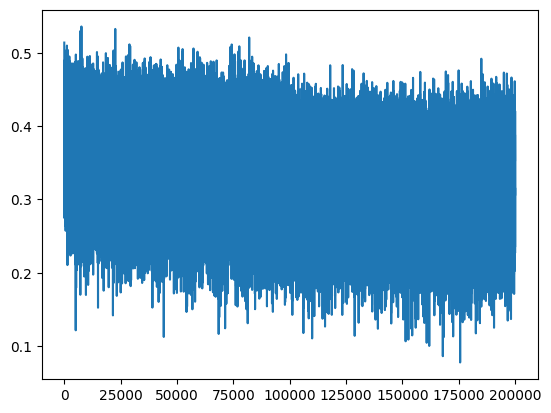

In [17]:
plt.plot(lossi)

In [18]:
# before fixing the initial loss, the losses were:
# train 2.1322224140167236
# val 2.170822858810425
split_loss('train')
split_loss('val')

train 2.0694169998168945
val 2.1424849033355713


# Tanh Saturation

The gradient of the tanh function is: $1 - tanh^2$. This means that if the output of the tanh function equals 1 or -1, the gradient will be zero and the neuron will not learn anything (dead neuron). This could happen at the start as a result of a bad initialization, and could happen during optimization due to a big learning rate pushing the weights of a tanh node to a place where it will always outputs 1 or -1 thus, will never get updated thus the weights will remain like that.
Another problem is that if the activations are zeros, the node will only pass the gradients, and will never contribute to the learning.

In [19]:
# two layer MLP
n_embd = 10
n_hidden = 200
vocab_size = len(stoi)

C = torch.randn((vocab_size, n_embd)) # random vectors to represent the vocabulary
W1 = torch.randn((n_embd * block_size, n_hidden))
b1 = torch.randn(n_hidden)
W2 = torch.randn((n_hidden, vocab_size)) * 0.01
b2 = torch.randn(27) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


In [20]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  emb = C[Xb] # (32x3x2)
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  h = torch.tanh(hpreact) # (32x6) @ (6x100) + (100) --> (32x100)
  logits = h @ W2 + b2 # (32x100) @ (100x27) + (27) --> (32x27)
  loss = F.cross_entropy(logits, Yb)

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = .1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():4f}')
  lossi.append(loss.log10().item())

  break

      0/ 200000: 3.266817


We can see that at the start, most h values are 1 and -1:

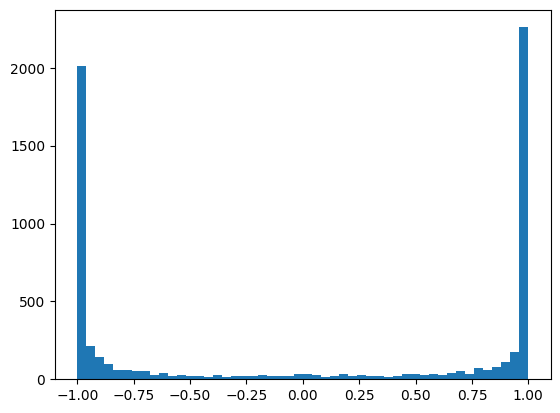

In [21]:
plt.hist(h.view(-1).tolist(), 50);

This happened because, the preactivations were very big:

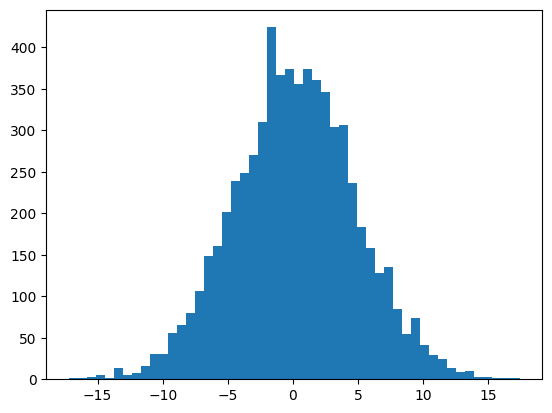

In [22]:
plt.hist(hpreact.view(-1).tolist(), 50);

Let's check if any neuron is dead. If any column in the image is totaly white, then there is a neuron always outputing 1 or -1 and will never be updated:

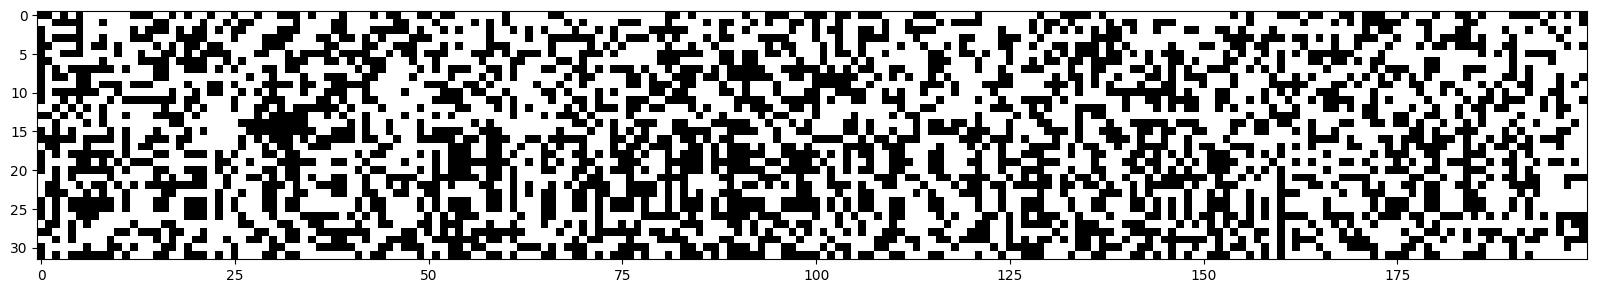

In [23]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

The solution to this problem is reducing the values of the preactivations by reducing the values of b1 and W1:

In [24]:
# two layer MLP
n_embd = 10
n_hidden = 200
vocab_size = len(stoi)

C = torch.randn((vocab_size, n_embd)) # random vectors to represent the vocabulary
W1 = torch.randn((n_embd * block_size, n_hidden)) * 0.1
b1 = torch.randn(n_hidden) * 0.01
W2 = torch.randn((n_hidden, vocab_size)) * 0.01
b2 = torch.randn(27) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


In [25]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  emb = C[Xb] # (32x3x2)
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  h = torch.tanh(hpreact) # (32x6) @ (6x100) + (100) --> (32x100)
  logits = h @ W2 + b2 # (32x100) @ (100x27) + (27) --> (32x27)
  loss = F.cross_entropy(logits, Yb)

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = .1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():4f}')
  lossi.append(loss.log10().item())

  break

      0/ 200000: 3.287750


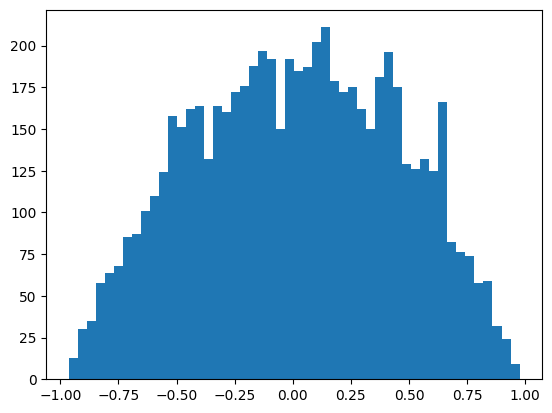

In [26]:
plt.hist(h.view(-1).tolist(), 50);

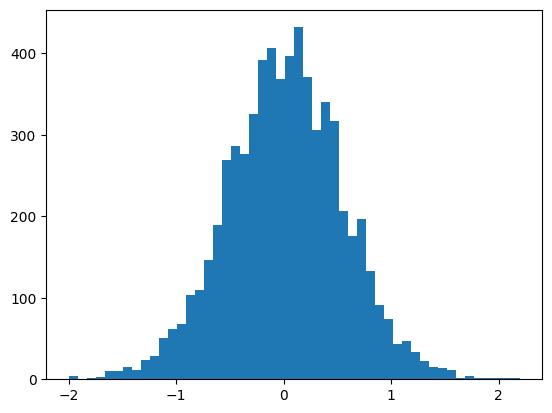

In [27]:
plt.hist(hpreact.view(-1).tolist(), 50);

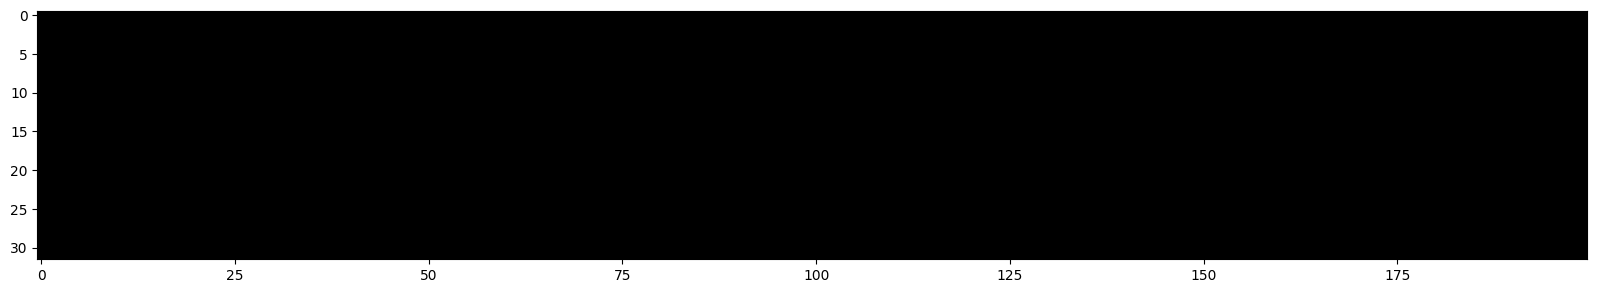

In [28]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

In [29]:
# two layer MLP
n_embd = 10
n_hidden = 200
vocab_size = len(stoi)

C = torch.randn((vocab_size, n_embd)) # random vectors to represent the vocabulary
W1 = torch.randn((n_embd * block_size, n_hidden)) * 0.1
b1 = torch.randn(n_hidden) * 0.01
W2 = torch.randn((n_hidden, vocab_size)) * 0.01
b2 = torch.randn(27) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


In [30]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  emb = C[Xb] # (32x3x2)
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  h = torch.tanh(hpreact) # (32x6) @ (6x100) + (100) --> (32x100)
  logits = h @ W2 + b2 # (32x100) @ (100x27) + (27) --> (32x27)
  loss = F.cross_entropy(logits, Yb)

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = .1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.305461
  10000/ 200000: 2.016545
  20000/ 200000: 2.015074
  30000/ 200000: 1.857771
  40000/ 200000: 1.972492
  50000/ 200000: 2.248127
  60000/ 200000: 2.256790
  70000/ 200000: 2.287789
  80000/ 200000: 2.103388
  90000/ 200000: 2.164308
 100000/ 200000: 2.048131
 110000/ 200000: 1.933197
 120000/ 200000: 2.112288
 130000/ 200000: 2.146332
 140000/ 200000: 1.906432
 150000/ 200000: 2.213983
 160000/ 200000: 2.297230
 170000/ 200000: 2.323620
 180000/ 200000: 2.283309
 190000/ 200000: 2.330548


In [31]:
# before fixing the initial loss, the losses were:
# train 2.1322224140167236
# val 2.170822858810425

# after fixing the initial loss but before fixing the activation issues, the losses were:
# train 2.0694169998168945
# val 2.1424849033355713
split_loss('train')
split_loss('val')

train 2.0622477531433105
val 2.1263434886932373


# Kaiming Init

We have used some numbers to ensure a good initialization for the weights, but where do these numbers came from? How should we set them?

tensor(-0.0103) tensor(0.9996)
tensor(-0.0086) tensor(3.0736)


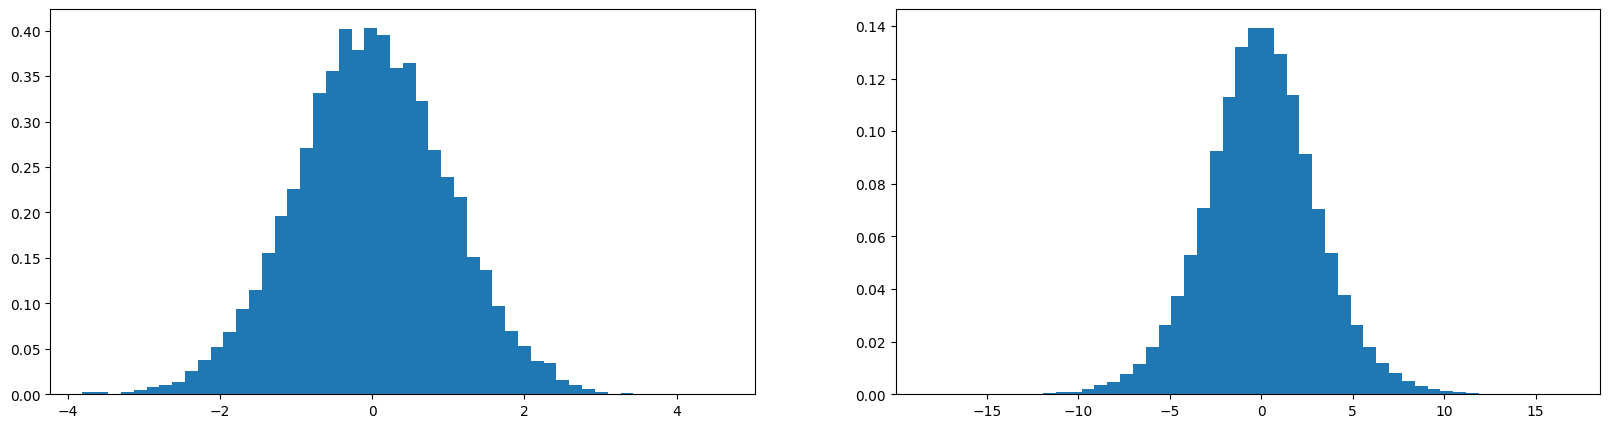

In [ ]:
x = torch.randn(1000,10)
w = torch.randn(10,200)
h = x @ w
print(x.mean(), x.std())
print(h.mean(), h.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(h.view(-1).tolist(), 50, density=True);

Despite the fact that our inputs and weights are normaly distributed with 0 mean 1 std, our activations were stretched with 3 std. This is not something we want, as to ensure numerical stability, we would like our activations to be normally distributed with 0 mean 1 std.

It turns out that we can multiply w by a number to retreive the stadard normal.

tensor(-0.0004) tensor(1.0032)
tensor(0.0012) tensor(1.0033)


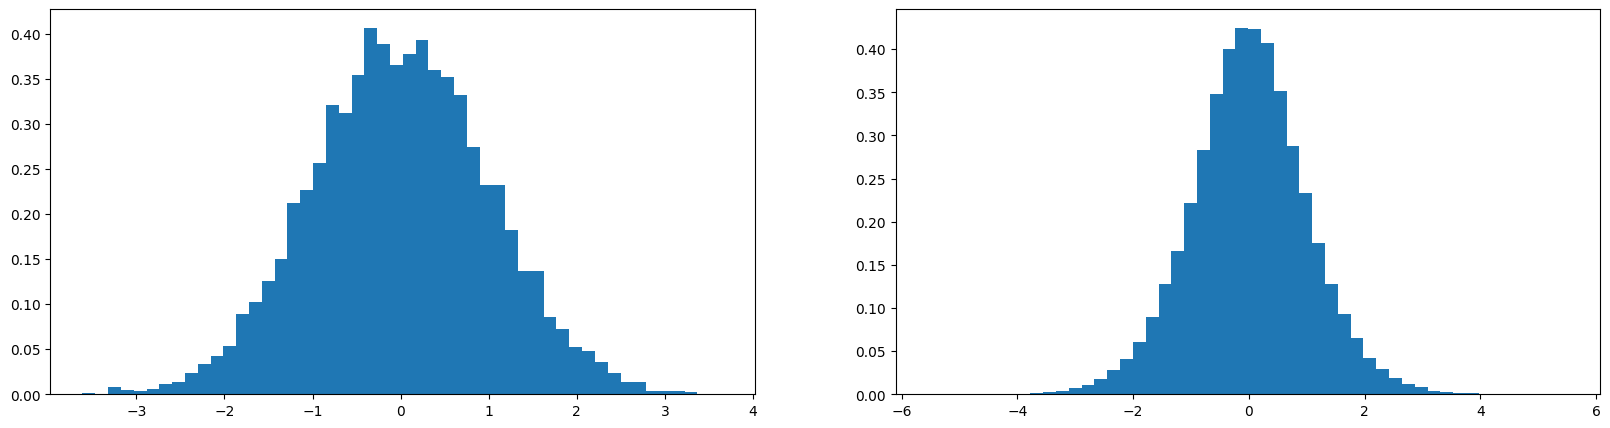

In [ ]:
x = torch.randn(1000,10)
w = torch.randn(10,200) / (10**0.5)
h = x @ w
print(x.mean(), x.std())
print(h.mean(), h.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(h.view(-1).tolist(), 50, density=True);

From Kaiming he et. al. paper, this number depends on the activation function and whether we would like to standardize the activations or the gradients. In our case, we would like to standardize the activations that rely on tanh nonlinearity, which throw away a lot of it's input. Thus, and we should compensate for that by multiplying with (5/3) (tanh specific). After that, we should standardize by dividing by $\sqrt{fin}$.

In [34]:
# The number we multiply with ends up the standard deviation
(torch.randn(10000,10) * 5).std()

tensor(5.0183)

In [35]:
# two layer MLP
n_embd = 10
n_hidden = 200
vocab_size = len(stoi)

C = torch.randn((vocab_size, n_embd)) # random vectors to represent the vocabulary
W1 = torch.randn((n_embd * block_size, n_hidden)) * (5/3) / ((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden) * 0.01
W2 = torch.randn((n_hidden, vocab_size)) * 0.01
b2 = torch.randn(27) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


In [36]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  emb = C[Xb] # (32x3x2)
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  h = torch.tanh(hpreact) # (32x6) @ (6x100) + (100) --> (32x100)
  logits = h @ W2 + b2 # (32x100) @ (100x27) + (27) --> (32x27)
  loss = F.cross_entropy(logits, Yb)

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = .1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.274113
  10000/ 200000: 2.355587
  20000/ 200000: 1.769019
  30000/ 200000: 2.024866
  40000/ 200000: 2.356542
  50000/ 200000: 1.962410
  60000/ 200000: 1.968230
  70000/ 200000: 1.948673
  80000/ 200000: 1.548790
  90000/ 200000: 2.407942
 100000/ 200000: 1.949589
 110000/ 200000: 2.229308
 120000/ 200000: 2.259799
 130000/ 200000: 1.833213
 140000/ 200000: 2.097257
 150000/ 200000: 2.422318
 160000/ 200000: 1.856748
 170000/ 200000: 2.154447
 180000/ 200000: 1.946962
 190000/ 200000: 1.846684


In [37]:
# before fixing the initial loss, the losses were:
# train 2.1322224140167236
# val 2.170822858810425

# after fixing the initial loss but before fixing the activation issues, the losses were:
# train 2.0694169998168945
# val 2.1424849033355713

# after fixing activation issues but before using Kaiming initialization , the losses were:
# train 2.0622477531433105
# val 2.1263434886932373
split_loss('train')
split_loss('val')

train 2.037795305252075
val 2.118175745010376


# Batch Nomalization

As we said earlier, if the preactivations were too big the tanh will saturate. If they were zeros the tanh will not contribute to the learning process. We ideally want the preactivations to be roughly zero mean 1 standard deviation. Now, we can acheive this by multiplying the weights as we did before, but a better approach would be to just standardize (subtract the mean and divide by the standard deviation). Another motivation for using batch normalization is that gussing the numbers we should multiply the weights with is tedious especially for deep networks.

Note that this behavior is desired only at the start of the training, we shouldn't force the preactivations to remain standard normal. To acheive this, we add a bias and a gain to allow the preactivations to move around.

Now, during training, we are using the statistics of a batch to standardize. During testing, we should be able to handle single instances in addition to batches. For this reason, we are going to calculate the mean and standard deviation for the training set and use these learned statistics during inference. Now, we can calculate these values on a separate phase, but they could be estimated during training in a running manner.

Note that, while standardizing the preactivations, we are removing any biases added before, for this reason, b1 is no longer necessary and will not be updated (his gradient will remain zeros) because it is not contributing to the learning process. Thus, we can remove it.

In [38]:
# two layer MLP
n_embd = 10
n_hidden = 200
vocab_size = len(stoi)

C = torch.randn((vocab_size, n_embd)) # random vectors to represent the vocabulary
W1 = torch.randn((n_embd * block_size, n_hidden)) * (5/3) / ((n_embd * block_size)**0.5)
# b1 = torch.randn(n_hidden) * 0.01
W2 = torch.randn((n_hidden, vocab_size)) * 0.01
b2 = torch.randn(27) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12097


In [39]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  emb = C[Xb] # (32x3x2)
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 #+ b1
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias

  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

  h = torch.tanh(hpreact) # (32x6) @ (6x100) + (100) --> (32x100)
  logits = h @ W2 + b2 # (32x100) @ (100x27) + (27) --> (32x27)
  loss = F.cross_entropy(logits, Yb)

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = .1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.274787
  10000/ 200000: 2.003522
  20000/ 200000: 2.381880
  30000/ 200000: 2.061561
  40000/ 200000: 2.084589
  50000/ 200000: 2.172403
  60000/ 200000: 2.014607
  70000/ 200000: 2.539610
  80000/ 200000: 2.572958
  90000/ 200000: 2.272022
 100000/ 200000: 1.782839
 110000/ 200000: 1.958253
 120000/ 200000: 1.887040
 130000/ 200000: 1.861669
 140000/ 200000: 1.754423
 150000/ 200000: 1.986776
 160000/ 200000: 2.529780
 170000/ 200000: 1.785851
 180000/ 200000: 1.920917
 190000/ 200000: 1.995564


In [40]:
@torch.no_grad()
def split_loss(split):
  x,y = {
      'train': (Xtr, Ytr),
      'val': (Xdev, Ydev),
      'test': (Xte, Yte),
  }[split]
  emb = C[x]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 #+ b1
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

In [41]:
# before fixing the initial loss, the losses were:
# train 2.1322224140167236
# val 2.170822858810425

# after fixing the initial loss but before fixing the activation issues, the losses were:
# train 2.0694169998168945
# val 2.1424849033355713

# after fixing activation issues but before using Kaiming initialization , the losses were:
# train 2.0622477531433105
# val 2.1263434886932373

# after using Kaiming initialization, but before using batch normalization the losses were:
# train 2.037795305252075
# val 2.118175745010376
split_loss('train')
split_loss('val')

train 2.0682339668273926
val 2.1189217567443848


# SUMMARY + PYTORCHIFYING

# Initialization

Without Batch normalization, the initialization of the weights affects the training very much.

Without tanh nonlinearity, we don't need to compensate for anything, so the gain would be 1 (no gain). With tanh nonlinearity, it is critical that we compensate (fight back) for the squeezing effect of tanh by multiplying with a gain of 5/3. (Andrej doesn't know where this number came from? but it emperically works).

In [5]:
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

In [41]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility
vocab_size = len(stoi)

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size),
]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      # try making this number higher or lower in two cases, with and without tanh layers
      # with tanh the correct gain is 5/3, without tanh it is 1
      layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

46497


In [25]:
layers

In [42]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function

  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    # update to data ratio
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.3040


layer 1 (Tanh): mean -0.03, std 0.77, saturated: 22.59%
layer 3 (Tanh): mean -0.01, std 0.73, saturated: 12.56%
layer 5 (Tanh): mean -0.01, std 0.73, saturated: 13.44%
layer 7 (Tanh): mean -0.04, std 0.73, saturated: 11.66%
layer 9 (Tanh): mean -0.00, std 0.71, saturated: 9.88%


Text(0.5, 1.0, 'activation distribution')

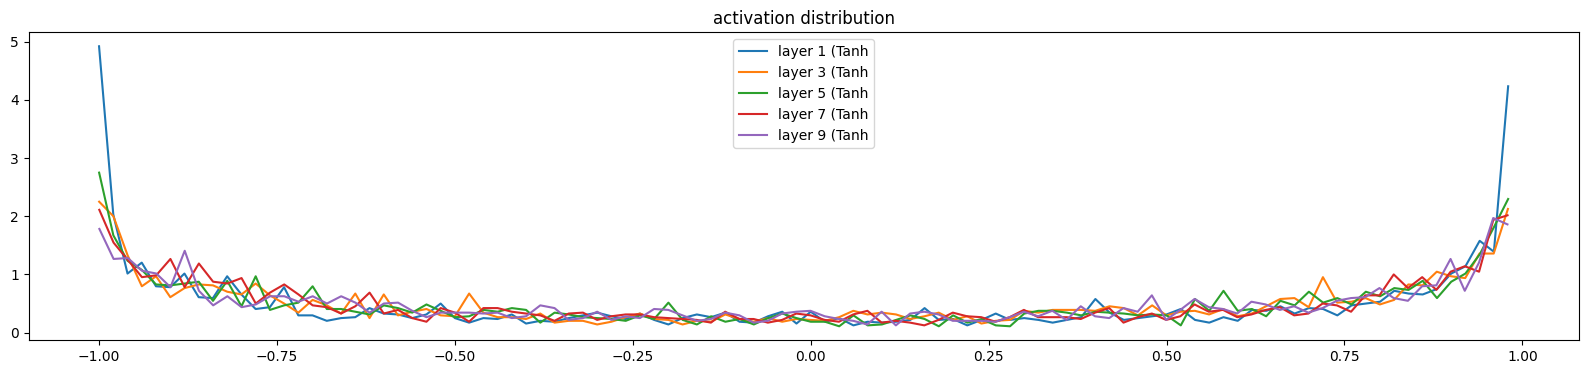

In [43]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 1 (      Tanh): mean -0.000066, std 2.802422e-03
layer 3 (      Tanh): mean -0.000024, std 2.801579e-03
layer 5 (      Tanh): mean +0.000002, std 2.809787e-03
layer 7 (      Tanh): mean +0.000094, std 2.825106e-03
layer 9 (      Tanh): mean +0.000006, std 2.324689e-03


Text(0.5, 1.0, 'gradient distribution')

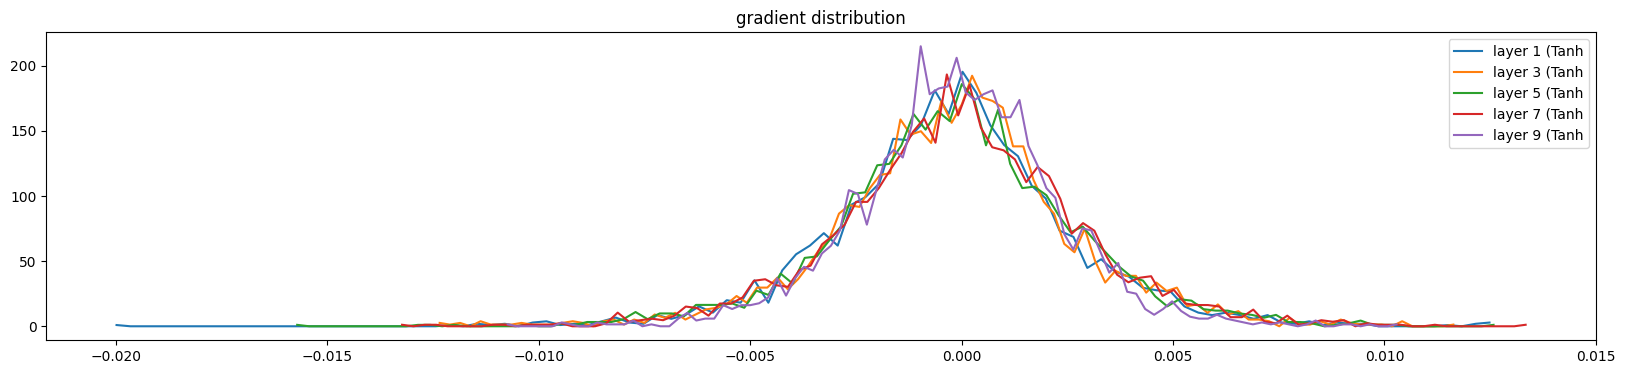

In [44]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000239 | std 1.012551e-02 | grad:data ratio 1.012007e-02
weight  (30, 100) | mean -0.000355 | std 8.248569e-03 | grad:data ratio 2.636214e-02
weight (100, 100) | mean -0.000082 | std 6.996077e-03 | grad:data ratio 4.160890e-02
weight (100, 100) | mean -0.000059 | std 6.494094e-03 | grad:data ratio 3.829964e-02
weight (100, 100) | mean -0.000029 | std 6.457503e-03 | grad:data ratio 3.828790e-02
weight (100, 100) | mean +0.000031 | std 5.748141e-03 | grad:data ratio 3.414672e-02
weight  (100, 27) | mean +0.000000 | std 2.343993e-02 | grad:data ratio 3.347796e-01


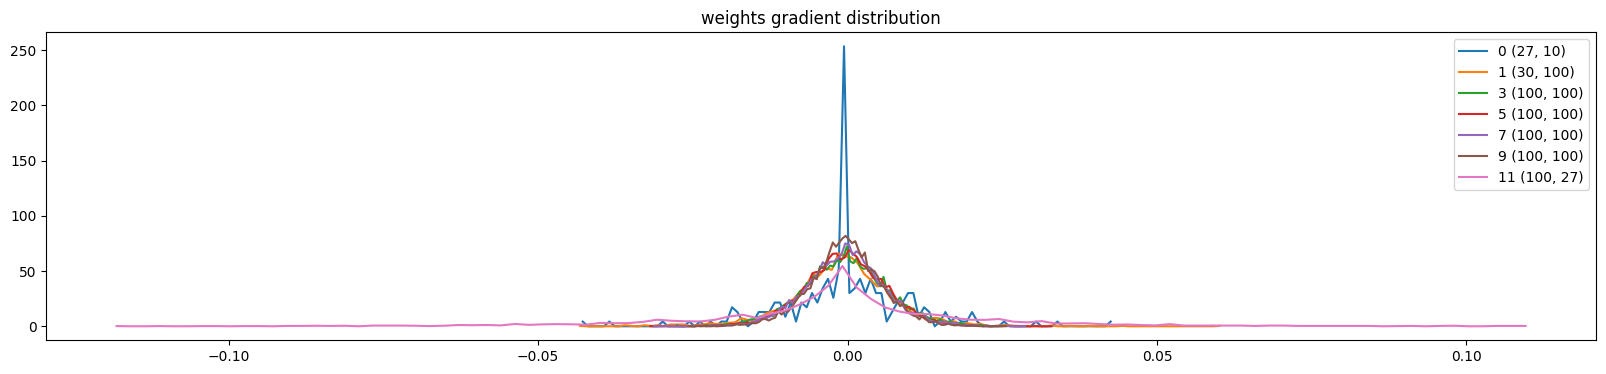

In [45]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

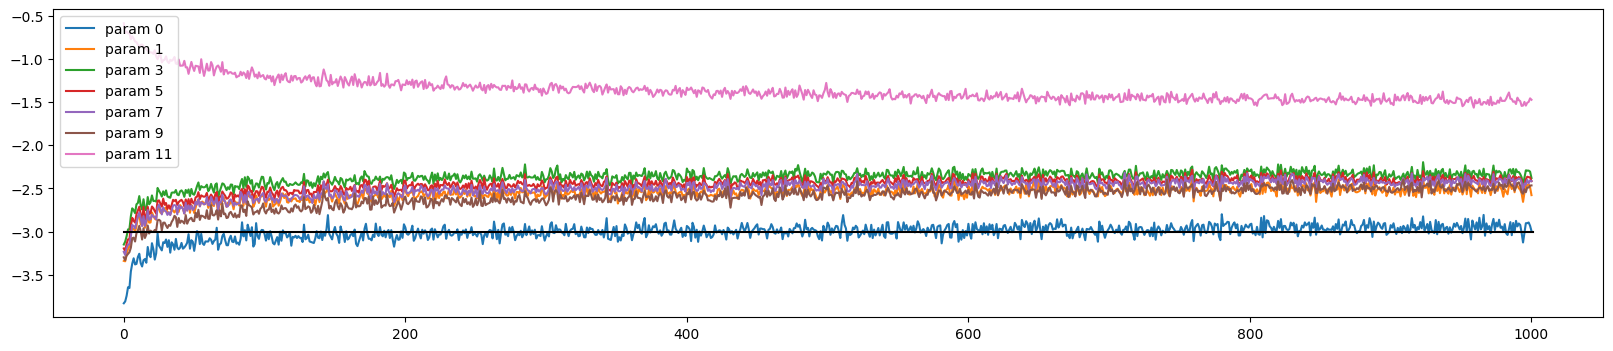

In [46]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);


In [47]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 2.343557596206665
val 2.35762882232666


In [48]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break

    print(''.join(itos[i] for i in out)) # decode and print the generated word

mria.
kayayleee.
medha.
alerenmrstendrleg.
adered.
eli.
jeli.
jel.
eden.
vananaraelyn.
malara.
nyshdbergshiries.
ken.
renelin.
nopuoriu.
zered.
ruyndue.
ehs.
kaysh.
shelan.


# Bonus Content

Content not covered in the video

In [49]:
# BatchNorm forward pass as a widget

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import scipy.stats as stats
import numpy as np

def normshow(x0):

  g = torch.Generator().manual_seed(2147483647+1)
  x = torch.randn(5, generator=g) * 5
  x[0] = x0 # override the 0th example with the slider
  mu = x.mean()
  sig = x.std()
  y = (x - mu)/sig

  plt.figure(figsize=(10, 5))
  # plot 0
  plt.plot([-6,6], [0,0], 'k')
  # plot the mean and std
  xx = np.linspace(-6, 6, 100)
  plt.plot(xx, stats.norm.pdf(xx, mu, sig), 'b')
  xx = np.linspace(-6, 6, 100)
  plt.plot(xx, stats.norm.pdf(xx, 0, 1), 'r')
  # plot little lines connecting input and output
  for i in range(len(x)):
    plt.plot([x[i],y[i]], [1, 0], 'k', alpha=0.2)
  # plot the input and output values
  plt.scatter(x.data, torch.ones_like(x).data, c='b', s=100)
  plt.scatter(y.data, torch.zeros_like(y).data, c='r', s=100)
  plt.xlim(-6, 6)
  # title
  plt.title('input mu %.2f std %.2f' % (mu, sig))

interact(normshow, x0=(-30,30,0.5));


interactive(children=(FloatSlider(value=0.0, description='x0', max=30.0, min=-30.0, step=0.5), Output()), _dom…

In [52]:
# Linear: activation statistics of forward and backward pass

g = torch.Generator().manual_seed(2147483647)

a = torch.randn((1000,1), requires_grad=True, generator=g)          # a.grad = b.T @ c.grad
b = torch.randn((1000,1000), requires_grad=True, generator=g)       # b.grad = c.grad @ a.T
c = b @ a
loss = torch.randn(1000, generator=g) @ c
a.retain_grad()
b.retain_grad()
c.retain_grad()
loss.backward()
print('a std:', a.std().item())
print('b std:', b.std().item())
print('c std:', c.std().item())
print('-----')
print('c grad std:', c.grad.std().item())
print('a grad std:', a.grad.std().item())
print('b grad std:', b.grad.std().item())

a std: 0.9875972270965576
b std: 1.0006722211837769
c std: 31.01241683959961
-----
c grad std: 0.9782556295394897
a grad std: 30.8818302154541
b grad std: 0.9666601419448853


In [53]:
# Linear + BatchNorm: activation statistics of forward and backward pass

g = torch.Generator().manual_seed(2147483647)

n = 1000
# linear layer ---
inp = torch.randn(n, requires_grad=True, generator=g)
w = torch.randn((n, n), requires_grad=True, generator=g) # / n**0.5
x = w @ inp
# bn layer ---
xmean = x.mean()
xvar = x.var()
out = (x - xmean) / torch.sqrt(xvar + 1e-5)
# ----
loss = out @ torch.randn(n, generator=g)
inp.retain_grad()
x.retain_grad()
w.retain_grad()
out.retain_grad()
loss.backward()

print('inp std: ', inp.std().item())
print('w std: ', w.std().item())
print('x std: ', x.std().item())
print('out std: ', out.std().item())
print('------')
print('out grad std: ', out.grad.std().item())
print('x grad std: ', x.grad.std().item())
print('w grad std: ', w.grad.std().item())
print('inp grad std: ', inp.grad.std().item())

inp std:  0.9875972270965576
w std:  1.0006722211837769
x std:  31.01241683959961
out std:  1.0
------
out grad std:  0.9782556295394897
x grad std:  0.031543977558612823
w grad std:  0.031169468536973
inp grad std:  0.9953053593635559
